#<h1> Sentiment Prediction on Movie reviews</h1>
<h3> Predict Sentiment on Movies Review </h3>

<b>Dataset Description


Files
  </b>
train.csv - the training set containing the review sentiment along with other features.
<br>
test.csv - the test set, has review features, but no sentiment column, since it is the target.
<br>
movies.csv - the file with metadata on movies.
<br><br>
<b>Columns</b><br>
movieid - named id of the movie <br>
sentiment - indicating "POSITIVE" or "NEGATIVE", which is the target.<br>
Other columns are self explanatory.<br>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


#<h1>Libraies

In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer # for y var, same as one-hot
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import gc

#<h1> Data Loading </h1>

In [ ]:
#movies dataset
dmovies="/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv"
movies=pd.read_csv(dmovies)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [ ]:
#sample dataset
dsample="/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv"
sample=pd.read_csv(dsample)
sample.head(2)

,id,sentiment
0,0,NEGATIVE
1,1,NEGATIVE


In [ ]:
# train dataset
dtrain="/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv"
train=pd.read_csv(dtrain)
train["reviewText"]=train["reviewText"].fillna(train["movieid"])
train.head(2)

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE


#<h3>Vectorization of  Train["reviewText"] </h3>

In [ ]:
# features ater hashing o review tokens
n_feature=500

train_hash=HashingVectorizer(n_features=n_feature)
train_review_hash=train_hash.fit_transform(train["reviewText"]).toarray()
train_review_hash.shape

(162758, 500)

In [ ]:
# test dataset
dtest="/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv"
test=pd.read_csv(dtest)
test["reviewText"]=test["reviewText"].fillna(test["movieid"])
# in train we have column name isfrequentreviewer but in test its istopicritic, so updating istopicrtitic to isfrequentreviewer
test["isFrequentReviewer"]=test["isTopCritic"]
test=test.drop(["isTopCritic"],axis=1)
test.head(2)

,movieid,reviewerName,reviewText,isFrequentReviewer
0,legend_marty_mcfly_oracle,John Kim,Green slowly cranks up the dread with style an...,False
1,terminator_katniss_everdeen_glimmer,Brian Chaney,Philip Noyce's direction is elegant and unforc...,False


In [ ]:
train_hash=HashingVectorizer(n_features=n_feature)
test_review_hash=train_hash.fit_transform(test["reviewText"]).toarray()
test_review_hash.shape

(55315, 500)

In [ ]:
train_review_hash

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21821789, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#<h1>  Data Cleaning: Movies Dataset</h1>

In [ ]:
movies.isna().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [ ]:
movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [ ]:
# creating a copy for testing purpose
d1=movies.copy()
d2=d1.dropna(axis=0, thresh=10)
df33=d2.reset_index()
print(df33.shape)

(25983, 15)


#<h1> Feature Imputation and Scaling </h1>

In [ ]:
cat_col=df33.select_dtypes(include=["object"]).columns
print("categorical col ",cat_col)
bool_col=df33.select_dtypes(include=["bool"]).columns
print("bool col ",bool_col)
num_col=df33.select_dtypes(exclude=["object","bool"]).columns
print("numerical col ",num_col)

categorical col  Index(['movieid', 'title', 'rating', 'ratingContents', 'releaseDateTheaters',
       'releaseDateStreaming', 'genre', 'originalLanguage', 'director',
       'boxOffice', 'distributor', 'soundType'],
      dtype='object')
bool col  Index([], dtype='object')
numerical col  Index(['index', 'audienceScore', 'runtimeMinutes'], dtype='object')


In [ ]:
# dierntiating oridinal and label encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
x=np.array(["a","b","c","c"]).reshape(-1,1)
le=LabelEncoder()
oe=OrdinalEncoder(categories=[["b","c","a"]])
oe.fit_transform(x)

array([[2.],
       [0.],
       [1.],
       [1.]])

In [ ]:
col=df33.columns
col

Index(['index', 'movieid', 'title', 'audienceScore', 'rating',
       'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming',
       'runtimeMinutes', 'genre', 'originalLanguage', 'director', 'boxOffice',
       'distributor', 'soundType'],
      dtype='object')

In [ ]:
cat_imp_pipe=Pipeline([("simp_imputer",SimpleImputer(strategy="most_frequent"))])
cat_imp_pipe1=Pipeline([("knn_imp",KNNImputer(n_neighbors=3)),("encoder", LabelEncoder()),("minmaxscaler",MinMaxScaler())]) # n-impute based on distance between points

# label encoder cannot work with column transfomer, you have to pass column one by one
cat_encoder_pipe=Pipeline([("encoder", LabelEncoder())])
num_imp_pipe=Pipeline([("imputer",SimpleImputer(strategy="mean")),("minmaxscaler",MinMaxScaler())])
norm_pip=Pipeline([("minmaxscaler",MinMaxScaler())])

In [ ]:
# pipeline for cat and num col
cat_imp_pipe=Pipeline([("simp_imputer",SimpleImputer(strategy="most_frequent"))])
num_imp_pipe=Pipeline([("imputer",SimpleImputer(strategy="mean"))])
#column transformer for cat and num col
column_transform_cat=ColumnTransformer(transformers=[("cat_impute",cat_imp_pipe,cat_col)],remainder='drop')
column_transform_num=ColumnTransformer(transformers=[("num_imp",num_imp_pipe,num_col)],remainder='drop')
# fitting column transformer
df41=pd.DataFrame(column_transform_cat.fit_transform(df33),columns=cat_col)
df42=pd.DataFrame(column_transform_num.fit_transform(df33),columns=num_col)

df5=pd.concat([df41,df42],axis=1)
df5

,movieid,title,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,boxOffice,distributor,soundType,index,audienceScore,runtimeMinutes
0,james_bond_courageous,James Bond Courageous,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic ...",2018-06-01,2018-08-21,"Adventure, Drama, Romance",English,Leroy Fernandes,$31.4M,STX Films,Surround,5.0,65.000000,120.0
1,jack_torrance_the_joker_luke_skywalker,Jack Torrance The Joker Luke Skywalker,R,['Language'],2002-03-22,2017-05-22,Drama,English,Lewis Horn,$11.5K,Passport Pictures,Surround,12.0,58.189507,98.0
2,dream_wonder_woman_zephyr_michael_corleone,Dream Wonder Woman Zephyr Michael Corleone,R,['Language'],2009-12-04,2017-05-22,Drama,Hindi,Crystal Medina,$199.2K,Big Pictures,Surround,17.0,67.000000,133.0
3,ellis_redding_silent,Ellis Redding Silent,R,['Language'],2011-09-30,2017-03-08,Documentary,English,Lee Dykstra,$10.5K,Freestyle Releasing,Surround,20.0,61.000000,90.0
4,sorcerer_wonder_woman_willy_wonka,Sorcerer Wonder Woman Willy Wonka,R,['Language'],2005-08-10,2007-06-11,Documentary,Korean,Zane Gooch,$41.5K,Kino Pictures,Surround,31.0,92.000000,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25978,jack_sparrow_indiana_jones_black_widow,Jack Sparrow Indiana Jones Black Widow,R,"['Violence', 'Language Throughout', 'Drug Use']",2021-07-16,2021-07-16,Mystery & thriller,English,Ralph Barraza,$1.1M,Vertical Entertainment,Surround,143213.0,43.000000,95.0
25979,enthralling_wolverine_secret_ellen_ripley,Enthralling Wolverine Secret Ellen Ripley,R,['Language'],1975-04-29,2000-02-08,Drama,English,Vesta Matthey,$1.1M,Columbia Pictures,Surround,143239.0,61.000000,88.0
25980,voyage_luke_skywalker_infinite,Voyage Luke Skywalker Infinite,R,['Language'],2018-09-14,2017-05-22,Comedy,English,Mark Lenz,$1.1M,Paramount Pictures,Dolby,143242.0,33.000000,81.0
25981,island_labyrinth_norman_bates_wolverine,Island Labyrinth Norman Bates Wolverine,PG-13,['Some Thematic Material'],2022-08-12,2017-05-22,Drama,English,Kylie Thomas,$55.9K,Bleecker Street,Surround,143247.0,40.000000,87.0


In [ ]:
df5.dtypes

movieid                  object
title                    object
rating                   object
ratingContents           object
releaseDateTheaters      object
releaseDateStreaming     object
genre                    object
originalLanguage         object
director                 object
boxOffice                object
distributor              object
soundType                object
index                   float64
audienceScore           float64
runtimeMinutes          float64
dtype: object

In [ ]:
df6=df5.groupby(by=["movieid","title"]).first()
df6.head()

,,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,boxOffice,distributor,soundType,index,audienceScore,runtimeMinutes
movieid,title,,,,,,,,,,,,,
adventure_captain_america_harry_potter,Adventure Captain America Harry Potter,PG-13,"['Mature Thematic Content', 'Family Dysfunctio...",2017-08-11,2017-11-07,"Biography, Drama",English,Michelle Rainey,$17.2M,Lionsgate Films,Surround,115950.0,70.0,127.0
adventure_captain_america_tyler_durden,Adventure Captain America Tyler Durden,R,['Language'],1998-05-01,1999-02-02,"Romance, Comedy",English,Samuel Ludwig,$302.2K,"Fox, 20th Century Fox","Surround, Dolby Digital",83177.0,76.0,109.0
adventure_celestial_ellen_ripley_the,Adventure Celestial Ellen Ripley The,R,['Language'],2015-10-16,2016-07-26,"Documentary, War",Russian,Linda Baer,$1.1M,FilmBuff,Surround,4315.0,67.0,81.0
adventure_celestial_mystery_hannibal_lecter,Adventure Celestial Mystery Hannibal Lecter,R,['Language'],2020-02-28,2020-04-01,"Comedy, Drama, Mystery & thriller",Romanian,Lena Higgins,$55.1K,Magnolia Pictures,Surround,66707.0,53.0,98.0
adventure_celestial_oracle,Adventure Celestial Oracle,PG-13,['Sex-Related Humor'],2005-03-24,2005-06-21,Comedy,English,Mary Choate,$48.5M,Warner Bros. Pictures,"Surround, Dolby SRD, DTS, SDDS",105354.0,42.0,115.0


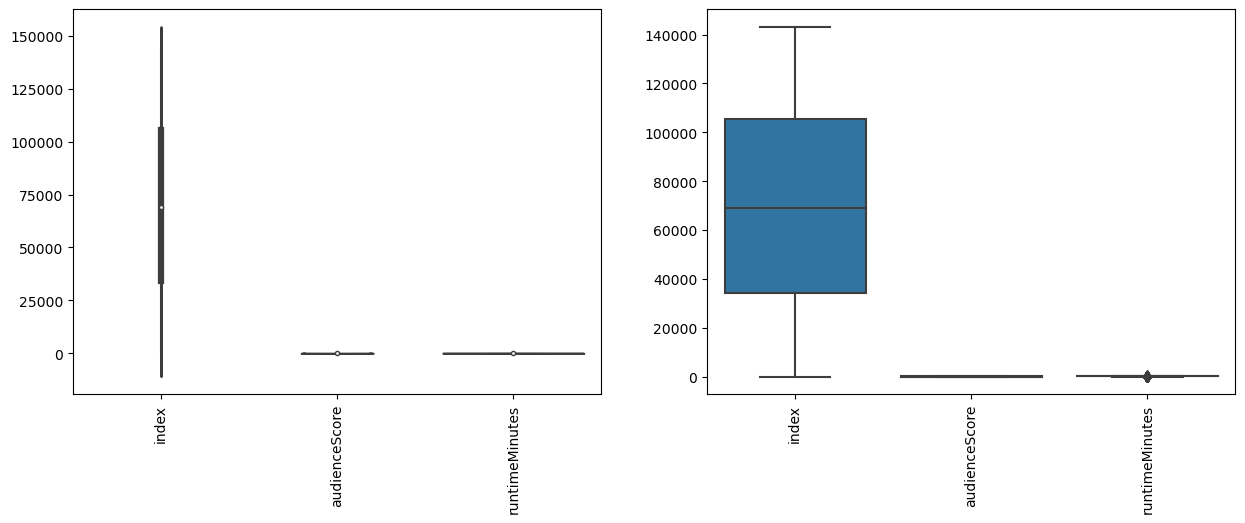

In [ ]:
plt.subplots(1,2, figsize=(15,5))
plt.subplot(1,2,1)
plot2=sns.violinplot(df6)
plot2.set_xticklabels(plot2.get_xticklabels(),rotation=90);
plt.subplot(1,2,2)
plot1=sns.boxplot(df6)
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90);

<h1>Note:Cleaned version of "movies" dataset is :- df6 </h1>
#<h3> Data Merging: new data=df6+train </h3>

In [ ]:
train1=pd.merge(train,df6,on="movieid",how="left")
test1=pd.merge(test,df6,on="movieid",how="left")
train1["boxOffice"]=train1["boxOffice"].replace(r'^\$','',regex=True).replace(r'M$','e6',regex=True).replace(r'K$','e3',regex=True).astype(float)
test1["boxOffice"]=test1["boxOffice"].replace(r'^\$','',regex=True).replace(r'M$','e6',regex=True).replace(r'K$','e3',regex=True).astype(float)


In [ ]:
train1.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,boxOffice,distributor,soundType,index,audienceScore,runtimeMinutes
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,1100000.0,Netflix,Surround,19837.0,65.0,105.0
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,PG-13,"['Some Sexual Material', 'Brief Partial Nudity']",2010-02-12,2010-05-18,"Holiday, Romance, Comedy, Lgbtq+",English,Hubert Dixon,110500000.0,Warner Bros.,"Dolby Digital, DTS",141650.0,47.0,119.0
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",2018-11-21,2019-02-12,Drama,English,Bobby Oleary,115700000.0,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",Surround,59220.0,80.0,130.0
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,R,"['Sexuality', 'Disturbing Images', 'Strong Vio...",2014-07-25,2015-01-20,"Action, Mystery & thriller, Sci-fi",English,Gail Pugh,126500000.0,Universal Pictures,Surround,80158.0,47.0,88.0
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,R,"['Language', 'Drug Content', 'Sexuality', 'Str...",2003-01-17,2004-06-08,"Crime, Drama",Portuguese (Brazil),John Trent,7600000.0,Miramax Films,"Surround, Dolby SR, Dolby Digital, Dolby A, Do...",33036.0,97.0,131.0


In [ ]:
gc.collect()

cat_col=train1.select_dtypes(include=["object"]).columns.to_numpy()
ind=np.where(cat_col=="reviewText")[0]
train1_cat_col=np.delete(cat_col,ind)

train1_num_col=train1.select_dtypes(exclude=["object"]).columns.to_numpy()

# pipeline for cat and num col
cat_imp_pipe=Pipeline([("simp_imputer",SimpleImputer(strategy="most_frequent"))])
num_imp_pipe=Pipeline([("imputer",SimpleImputer(strategy="mean"))])
#column transformer for cat and num col
column_transform_cat=ColumnTransformer(transformers=[("cat_impute",cat_imp_pipe,train1_cat_col)],remainder='drop')
column_transform_num=ColumnTransformer(transformers=[("num_imp",num_imp_pipe,train1_num_col)],remainder='drop')
gc.collect()
# fitting column transformer
df41=pd.DataFrame(column_transform_cat.fit_transform(train1),columns=train1_cat_col)
df42=pd.DataFrame(column_transform_num.fit_transform(train1),columns=train1_num_col)

train2=pd.concat([df41,df42],axis=1)
gc.collect()
train2.info()
del df41
del df42
gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               162758 non-null  object 
 1   reviewerName          162758 non-null  object 
 2   sentiment             162758 non-null  object 
 3   rating                162758 non-null  object 
 4   ratingContents        162758 non-null  object 
 5   releaseDateTheaters   162758 non-null  object 
 6   releaseDateStreaming  162758 non-null  object 
 7   genre                 162758 non-null  object 
 8   originalLanguage      162758 non-null  object 
 9   director              162758 non-null  object 
 10  distributor           162758 non-null  object 
 11  soundType             162758 non-null  object 
 12  isFrequentReviewer    162758 non-null  float64
 13  boxOffice             162758 non-null  float64
 14  index                 162758 non-null  float64
 15  

0

In [ ]:
train2

,movieid,reviewerName,sentiment,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,distributor,soundType,isFrequentReviewer,boxOffice,index,audienceScore,runtimeMinutes
0,marvelous_pirate,Benjamin Henry,POSITIVE,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,Netflix,Surround,0.0,1100000.0,19837.0,65.0,105.0
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,NEGATIVE,PG-13,"['Some Sexual Material', 'Brief Partial Nudity']",2010-02-12,2010-05-18,"Holiday, Romance, Comedy, Lgbtq+",English,Hubert Dixon,Warner Bros.,"Dolby Digital, DTS",0.0,110500000.0,141650.0,47.0,119.0
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,POSITIVE,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",2018-11-21,2019-02-12,Drama,English,Bobby Oleary,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",Surround,1.0,115700000.0,59220.0,80.0,130.0
3,lara_croft_glimmer,Ryan Barrett,POSITIVE,R,"['Sexuality', 'Disturbing Images', 'Strong Vio...",2014-07-25,2015-01-20,"Action, Mystery & thriller, Sci-fi",English,Gail Pugh,Universal Pictures,Surround,0.0,126500000.0,80158.0,47.0,88.0
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,POSITIVE,R,"['Language', 'Drug Content', 'Sexuality', 'Str...",2003-01-17,2004-06-08,"Crime, Drama",Portuguese (Brazil),John Trent,Miramax Films,"Surround, Dolby SR, Dolby Digital, Dolby A, Do...",0.0,7600000.0,33036.0,97.0,131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,POSITIVE,R,['Language'],2012-09-21,2013-06-11,"History, Drama",Korean,Jamie Rodriguez,CJ Entertainment,Surround,0.0,922600.0,38156.0,89.0,131.0
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,NEGATIVE,PG-13,"['Crude and Sexual Content', 'Brief Strong Lan...",2016-02-12,2016-05-24,"Comedy, Adventure",English,Susan Oley,Paramount Pictures,Surround,1.0,28800000.0,110785.0,20.0,102.0
162755,infinite_enigma_luke_skywalker,Bryan Wilson,POSITIVE,PG-13,"['Some Language', 'Suggestive References']",2018-09-14,2022-06-17,"Comedy, Drama",English,Bryant Reams,Paramount Pictures,Dolby Digital,0.0,1100000.0,126368.0,78.0,90.0
162756,emerald_oracle_iron_man_wolverine,Erik Parker,NEGATIVE,R,['Language'],1996-11-16,1998-11-03,"Kids & family, Holiday, Comedy",English,Lisa Cruz,20th Century Fox,Surround,0.0,60600000.0,141270.0,39.0,88.0


## Train  data prep

In [ ]:
train2_cat_col=train2.select_dtypes(include=["object"]).columns.to_numpy()
train2_cat_col

le=LabelEncoder()
for ccol in train2_cat_col:
    print(ccol)
    train2[ccol]=le.fit_transform(train2[ccol])
norm_pip=Pipeline([("minmaxscaler",MinMaxScaler())])
nom_colum_transform=ColumnTransformer(transformers=[("min max",norm_pip,train2.columns)])
train22=pd.DataFrame(nom_colum_transform.fit_transform(train2),columns=train2.columns)
train3=pd.concat([train22,pd.DataFrame(train_review_hash).add_prefix("hash_")],axis=1)
del train22
del train2
del train_review_hash
gc.collect

movieid
reviewerName
sentiment
rating
ratingContents
releaseDateTheaters
releaseDateStreaming
genre
originalLanguage
director
distributor
soundType


<function gc.collect(generation=2)>

In [ ]:
# final data
train3

,movieid,reviewerName,sentiment,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,...,hash_490,hash_491,hash_492,hash_493,hash_494,hash_495,hash_496,hash_497,hash_498,hash_499
0,0.606210,0.101986,1.0,0.333333,0.967624,0.990242,0.975041,0.225198,0.207792,0.076923,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.852002,0.337871,0.0,0.333333,0.777823,0.744084,0.322831,0.570437,0.207792,0.381778,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.105645,0.702968,1.0,0.333333,0.266896,0.915345,0.721768,0.365079,0.207792,0.092686,...,0.0,-0.218218,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.544108,0.820129,1.0,0.500000,0.623027,0.827519,0.465630,0.092262,0.207792,0.328815,...,0.0,0.000000,0.0,0.152499,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.496639,0.021201,1.0,0.500000,0.340955,0.577946,0.155892,0.301587,0.701299,0.479035,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.204124,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162753,0.835167,0.243249,1.0,0.500000,0.419263,0.792144,0.416939,0.506944,0.480519,0.412358,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
162754,0.158408,0.428029,0.0,0.333333,0.083165,0.858746,0.516776,0.217262,0.207792,0.905580,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
162755,0.432514,0.147958,1.0,0.333333,0.724605,0.911198,0.954583,0.233135,0.207792,0.112390,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
162756,0.196300,0.330060,0.0,0.500000,0.419263,0.433032,0.018822,0.725198,0.207792,0.593947,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


#<h4> Test Data Prep </h4>

In [ ]:
cat_col=test1.select_dtypes(include=["object"]).columns.to_numpy()
ind=np.where(cat_col=="reviewText")[0]
test1_cat_col=np.delete(cat_col,ind)

test1_num_col=test1.select_dtypes(exclude=["object"]).columns
# pipeline for cat and num col
cat_imp_pipe=Pipeline([("simp_imputer",SimpleImputer(strategy="most_frequent"))])
num_imp_pipe=Pipeline([("imputer",SimpleImputer(strategy="mean"))])
#column transformer for cat and num col
column_transform_cat=ColumnTransformer(transformers=[("cat_impute",cat_imp_pipe,test1_cat_col)],remainder='drop')
column_transform_num=ColumnTransformer(transformers=[("num_imp",num_imp_pipe,test1_num_col)],remainder='drop')
# fitting column transformer
df41=pd.DataFrame(column_transform_cat.fit_transform(test1),columns=test1_cat_col)
df42=pd.DataFrame(column_transform_num.fit_transform(test1),columns=test1_num_col)

test2=pd.concat([df41,df42],axis=1)
test2.info()

del df41
del df42
gc.collect()
# test2=test11
# for i in encode_review.columns:
#     test2=pd.concat([test2,encode_review[i]],axis=1)
#     gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movieid               55315 non-null  object 
 1   reviewerName          55315 non-null  object 
 2   rating                55315 non-null  object 
 3   ratingContents        55315 non-null  object 
 4   releaseDateTheaters   55315 non-null  object 
 5   releaseDateStreaming  55315 non-null  object 
 6   genre                 55315 non-null  object 
 7   originalLanguage      55315 non-null  object 
 8   director              55315 non-null  object 
 9   distributor           55315 non-null  object 
 10  soundType             55315 non-null  object 
 11  isFrequentReviewer    55315 non-null  float64
 12  boxOffice             55315 non-null  float64
 13  index                 55315 non-null  float64
 14  audienceScore         55315 non-null  float64
 15  runtimeMinutes     

52

In [ ]:
le=LabelEncoder()
test2_cat_col=test2.select_dtypes(include=["object"]).columns.to_numpy()
for ccol in test2_cat_col:
    print(ccol)
    test2[ccol]=le.fit_transform(test2[ccol])
nom_colum_transform=ColumnTransformer(transformers=[("min max",norm_pip,test2.columns)])
test22=pd.DataFrame(nom_colum_transform.fit_transform(test2),columns=test2.columns)
test3=pd.concat([test22,pd.DataFrame(test_review_hash).add_prefix("hash_")],axis=1)
del test22
del test2
del test_review_hash
gc.collect

movieid
reviewerName
rating
ratingContents
releaseDateTheaters
releaseDateStreaming
genre
originalLanguage
director
distributor
soundType


<function gc.collect(generation=2)>

In [ ]:
# final train code
test3

,movieid,reviewerName,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,distributor,...,hash_490,hash_491,hash_492,hash_493,hash_494,hash_495,hash_496,hash_497,hash_498,hash_499
0,0.551028,0.467957,0.500000,0.167139,0.989484,0.972995,0.560199,0.207792,0.853582,0.899881,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.824486,0.132844,0.166667,0.158225,0.573490,0.123977,0.370149,0.207792,0.165194,0.575089,...,0.0,-0.19245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.473935,0.242991,0.500000,0.419571,0.910981,0.593290,0.364179,0.207792,0.088514,0.652563,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.901221,0.141522,0.500000,0.419571,0.966251,0.902619,0.415920,0.207792,0.426791,0.598927,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.211498,0.510681,0.500000,0.419571,0.910981,0.593290,0.364179,0.207792,0.088514,0.652563,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55310,0.066428,0.482421,0.333333,0.592180,0.759354,0.352700,0.205970,0.207792,0.453929,0.899881,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55311,0.929520,0.927236,0.500000,0.419571,0.792859,0.409165,0.243781,0.207792,0.200379,0.430870,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55312,0.759190,0.504895,0.333333,0.318071,0.583761,0.134615,0.205970,0.207792,0.634585,0.197259,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55313,0.822878,0.939920,0.333333,0.598865,0.626070,0.169394,0.778109,0.207792,0.443200,0.550060,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#<h1>visualization</h1>

In [ ]:
gc.collect()

54

<Axes: ylabel='Density'>

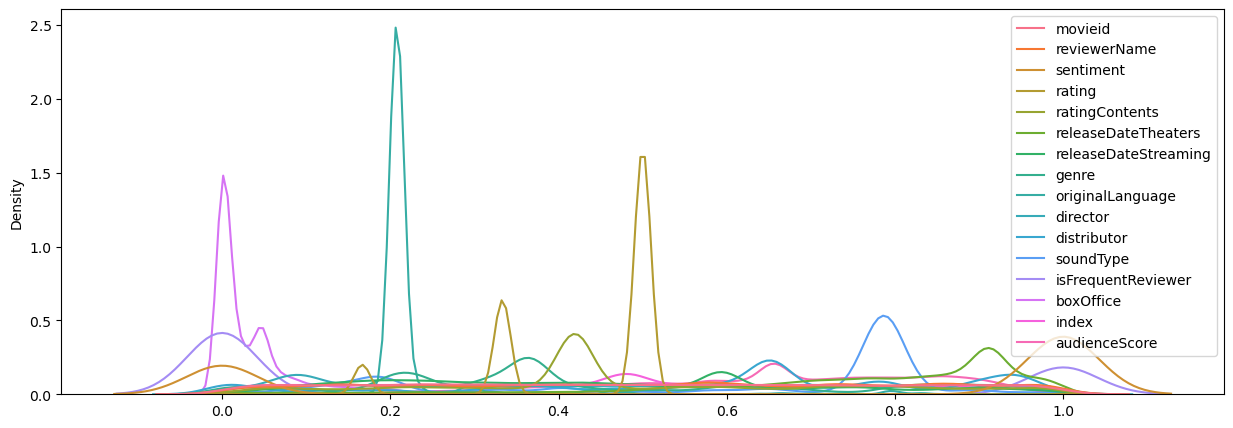

In [ ]:
plt.subplots(figsize=(15,5))
sns.kdeplot(train3.iloc[:,:16])

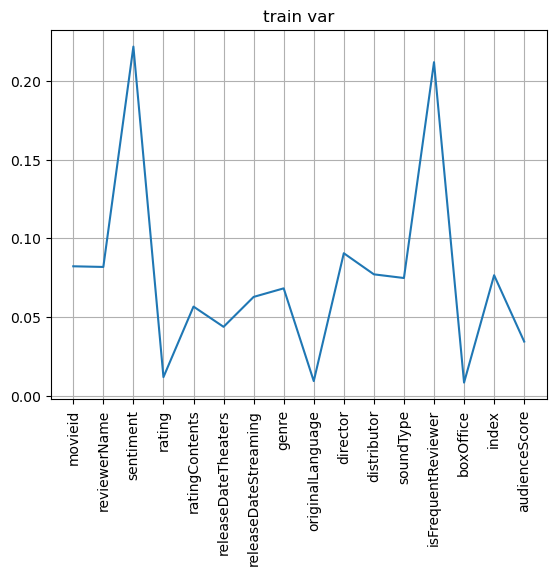

In [ ]:
plt.plot(train3.iloc[:,:16].var())
plt.xticks(train3.iloc[:,:16].columns,rotation=90);
plt.title("train var")
plt.grid(True)

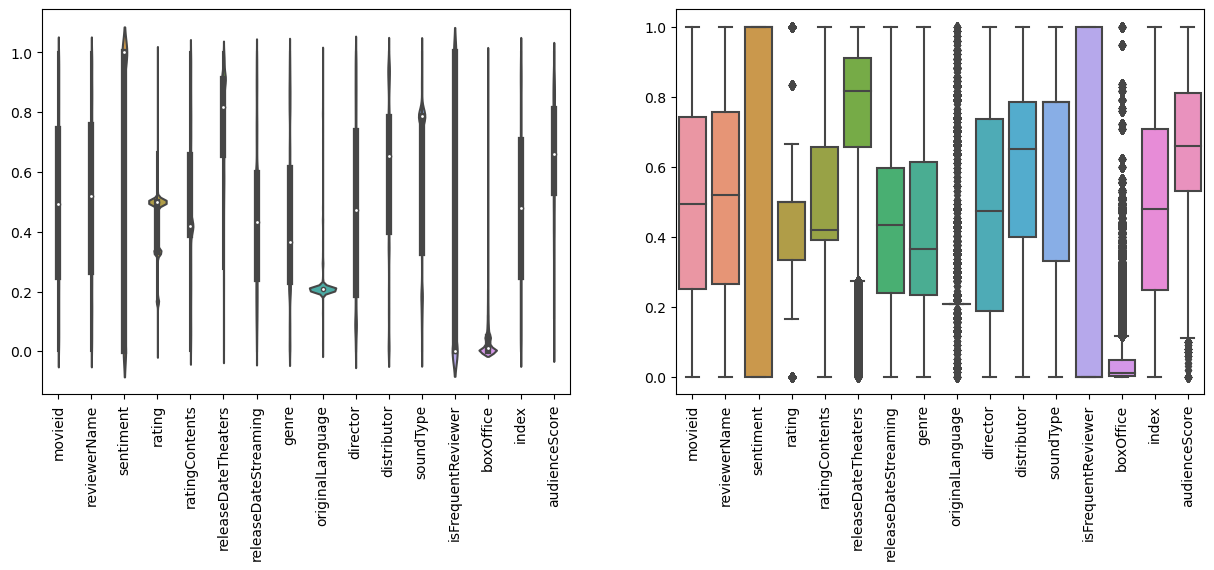

In [ ]:
plt.subplots(1,2, figsize=(15,5))
plt.subplot(1,2,1)
plot2=sns.violinplot(train3.iloc[:,:16])
plot2.set_xticklabels(plot2.get_xticklabels(),rotation=90);
plt.subplot(1,2,2)
plot1=sns.boxplot(train3.iloc[:,:16])
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90);

<Axes: >

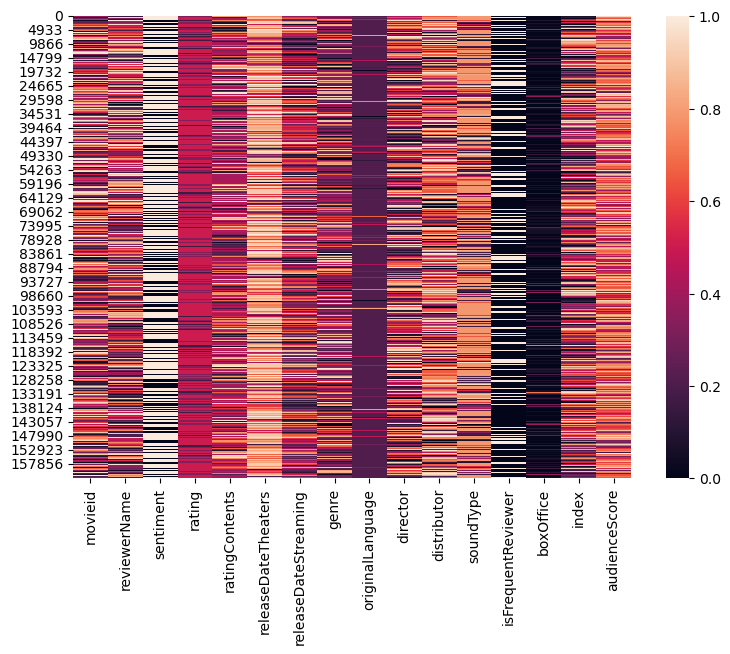

In [ ]:
im, axis=plt.subplots(figsize=(9,6))
sns.heatmap(train3.iloc[:,:16])

#<h1> Feature Selection </h1>

In [ ]:
# # eature selection using variance: var must be greater than threshold
# from sklearn.feature_selection import VarianceThreshold
# vat= VarianceThreshold(threshold=0)
# new_data=vat.fit_transform(train3)
# train3=pd.DataFrame(new_data, columns=vat.feature_names_in_)

In [ ]:
# # feature selection using mutual_info_regression
# from sklearn.feature_selection import mutual_info_regression
# mir_data=mutual_info_regression(trainx,trainy)
# print(mir_data)
# plt.plot(trainx.columns,mir_data);
# plt.xticks(rotation=90);
# plt.grid(True)
# plt.title("Mutual Info Regression")

In [ ]:
# # feature selection using selectkbest
# from sklearn.feature_selection import SelectKBest, chi2
# skb1=SelectKBest(chi2,k=16)
# skb2=SelectKBest(mutual_info_regression, k=16)

# skb_data=skb1.fit_transform(trainx,trainy)
# skb_data.shape

In [ ]:
# # feature selection based on percentile
# from sklearn.feature_selection import SelectPercentile, chi2
# sp=SelectPercentile(chi2, percentile=100) # percentile= n% of fetaure keep
# sp_data=sp.fit_transform(trainx,trainy)
# sp_data.shape

In [ ]:
# # feature selection using recursive feature elimination
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# model=LogisticRegression()

# rfe=RFE(estimator=model,n_features_to_select=16, step=2) # step says how many we should eleiminate ata time
# rfe.fit_transform(trainx,trainy)

# # true says feature is selected, false says it unselected
# rfe.support_

In [ ]:
# # feature selection using  SequentialFeatureSelection
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.linear_model import LogisticRegression

# model=LogisticRegression()
# sfs=SequentialFeatureSelector(estimator=model,n_features_to_select=15, direction="backward")
# #sfs.fit(trainx,trainy)

# # true says feature is selected, false says it unselected
# #sfs.support_

In [ ]:
train3.iloc[:,:16].corr()

,movieid,reviewerName,sentiment,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,distributor,soundType,isFrequentReviewer,boxOffice,index,audienceScore
movieid,1.000000,-0.003693,0.004118,-0.001617,-0.005055,0.004593,0.008530,-0.000787,-0.014969,-0.011601,-0.014855,0.014002,-0.001774,0.006681,0.025205,-0.000567
reviewerName,-0.003693,1.000000,-0.021787,-0.005491,0.003954,-0.021898,-0.018370,-0.000125,-0.003897,-0.002201,-0.003746,0.010142,-0.013435,-0.008382,-0.003853,-0.004375
sentiment,0.004118,-0.021787,1.000000,0.069754,-0.012102,0.029011,0.100128,-0.025420,0.076024,-0.022636,-0.037488,0.031006,-0.050806,0.010848,-0.001944,0.321893
rating,-0.001617,-0.005491,0.069754,1.000000,-0.121485,-0.090890,-0.005146,-0.076442,0.070828,-0.077729,-0.061189,0.240101,0.010040,-0.276354,-0.045706,-0.014125
ratingContents,-0.005055,0.003954,-0.012102,-0.121485,1.000000,0.029709,-0.009457,0.059331,-0.006298,0.044284,0.001688,-0.043270,-0.002691,-0.005669,-0.034877,0.027884
releaseDateTheaters,0.004593,-0.021898,0.029011,-0.090890,0.029709,1.000000,0.728691,-0.069139,0.013443,-0.073695,0.034318,-0.143071,-0.006417,0.055488,0.017382,-0.082064
releaseDateStreaming,0.008530,-0.018370,0.100128,-0.005146,-0.009457,0.728691,1.000000,-0.032149,0.034489,-0.059489,0.001273,-0.144654,-0.044229,-0.001897,0.000168,0.054129
genre,-0.000787,-0.000125,-0.025420,-0.076442,0.059331,-0.069139,-0.032149,1.000000,-0.017906,-0.001212,-0.022425,-0.024300,-0.011195,-0.024340,-0.032157,-0.069112
originalLanguage,-0.014969,-0.003897,0.076024,0.070828,-0.006298,0.013443,0.034489,-0.017906,1.000000,0.033309,-0.014344,0.030572,0.016625,-0.107105,-0.031912,0.112185
director,-0.011601,-0.002201,-0.022636,-0.077729,0.044284,-0.073695,-0.059489,-0.001212,0.033309,1.000000,-0.022673,-0.099732,-0.004665,0.022910,0.013622,0.017901


<h1> Model Selection </h1>

In [ ]:
# matrix for concluded comprison of models and their perormances
final_accuracy={}

1.0    108761
0.0     53997
Name: sentiment, dtype: int64


Text(0.5, 1.0, ' Class Imbalance Checking')

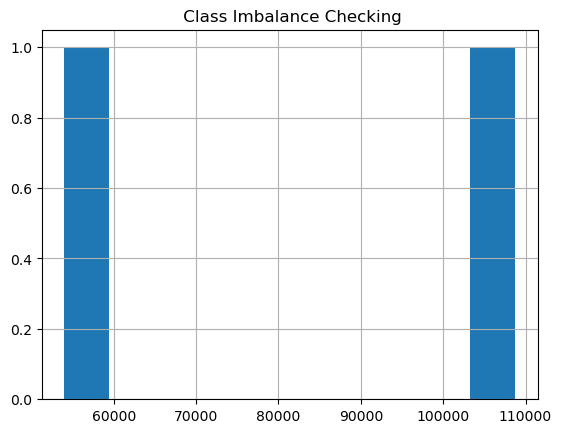

In [ ]:
# checking class imbalance
# checking class imbalance in dataset uding histogram
train3["sentiment"].value_counts().hist()
print(train3["sentiment"].value_counts())
plt.title(" Class Imbalance Checking")

In [ ]:
# for submission
def submit(pred):
    pred=pred.astype(str);
    pred[pred=="1.0"]="POSITIVE"
    pred[pred=="0.0"]="NEGATIVE"
    result=pd.DataFrame(np.arange(0,pred.shape[0],1),columns=["id"])
    result["sentiment"]=pred
    return result


In [ ]:
# train test split
# from sklearn.model_selection import StratifiedShuffleSplit

trainx=train3.drop(["sentiment"], axis=1)
trainy=train3["sentiment"]

sss=StratifiedShuffleSplit(n_splits=1,test_size=0.25)
for train_index,test_index in sss.split(trainx,trainy):
    sss_train=train3.iloc[train_index]
    sss_test=train3.iloc[test_index]
del trainx
del trainy
del train3

In [ ]:
key=list(locals().keys())
for i in key:
    k1=i
    #validation_curve
    #print(sys.getsizeof(locals()["validation_curve"])/1024**3)

    sz=sys.getsizeof(locals()[i])/1024**3
    if (sz>1/1024):
        if(i not in ["sss_train","sss_test","test3"]):
            print(i,sz)
            del locals()[i]
            gc.collect()
gc.collect()

movies 0.08974038809537888
sample 0.003760810010135174
train 0.06287471298128366
test 0.01799332443624735
_9 0.6063209176063538
d1 0.08974038809537888
d2 0.01970480289310217
df33 0.01970492210239172
df5 0.021785961464047432
_17 0.021785961464047432
df6 0.020538071170449257
_19 0.004146485589444637
train1 0.1635471899062395
test1 0.05142066162079573
_24 0.020615041255950928
_26 0.6269358396530151
_29 0.21265862882137299


0

<h3>1- Dummy Clasifier </h3>

In [ ]:
# dummy classiier

model0=DummyClassifier(strategy="most_frequent")
model0.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
dummy_pred=model0.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],dummy_pred)
final_accuracy["Dummy Classiier"]=acc
print(acc)
pred0=model0.predict(test3)
pred0

0.6682477267141804


array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
pred0=submit(pred0)
pred0

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE


<h2> 3-SVC </h2>

In [ ]:
# from sklearn.svm import SVC
# model2=SVC()
# model2.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
# svc_pred2=model2.predict(sss_test.drop(["sentiment"], axis=1))
# acc=accuracy_score(sss_test["sentiment"],svc_pred2)
# print(acc)
# final_accuracy["SVC Classiier"]=acc
# pred2=model2.predict(test3)
# pred2=submit(pred2)
# pred2

<h2> 4-KNN </h2>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
knn_pred1=knn.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],knn_pred1)
print(acc)
pred1=knn.predict(test3)
pred1=submit(pred1)
pred1

0.6801179651019906


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,NEGATIVE


<h5> KNN: Param search </h5>

In [ ]:
gc.collect()

0

In [ ]:
# validation curve: or varying param
from sklearn.model_selection import validation_curve

knn=KNeighborsClassifier(n_neighbors=3)
n_neigh=np.linspace(1,10,5).astype(int)
cv=5
train_loss,test_loss=validation_curve(knn,sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"],cv=cv,param_name="n_neighbors",param_range=n_neigh)
train_loss,test_loss

(array([[0.99998976, 1.        , 0.99998976, 0.99998976, 1.        ],
        [0.82744178, 0.82667377, 0.82785139, 0.82749475, 0.82665506],
        [0.78793495, 0.78638868, 0.78734102, 0.78782448, 0.7876504 ],
        [0.76866283, 0.76883691, 0.76954349, 0.76965849, 0.76790743],
        [0.76016343, 0.76170971, 0.76064473, 0.7607291 , 0.76042189]]),
 array([[0.6576964 , 0.64970918, 0.65335463, 0.65108754, 0.6530537 ],
        [0.67756205, 0.68010158, 0.67866798, 0.67718019, 0.67861385],
        [0.69054641, 0.69107889, 0.68927664, 0.68774833, 0.69143489],
        [0.69812403, 0.69509298, 0.69615794, 0.69577684, 0.69737435],
        [0.69796019, 0.70000819, 0.69976243, 0.7013886 , 0.69852128]]))

In [ ]:
max_acc_indx=np.argmax(test_loss.sum(axis=1)/cv)
opt_nneigh=n_neigh[max_acc_indx]
print("average test acc ",(test_loss.sum(axis=1)/cv)[max_acc_indx]," with n neighbour= ",opt_nneigh)

average test acc  0.6995281388538058  with n neighbour=  10


In [ ]:
knn=KNeighborsClassifier(n_neighbors=opt_nneigh)
knn.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
pred_knn=knn.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred_knn)
print(acc)
final_accuracy["KNN Classiier"]=acc
pred_knn0=knn.predict(test3)
pred_knn0=submit(pred_knn0)
pred_knn0

0.7004177930695502


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,POSITIVE
55312,55312,NEGATIVE
55313,55313,NEGATIVE


<h1> 5-Decision Tree</h1>

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
dcc=DecisionTreeClassifier()
score=cross_val_score(dcc,sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"],cv=10,scoring="accuracy")
score

array([0.66379946, 0.66674859, 0.66183337, 0.66085033, 0.66347178,
       0.66257066, 0.66183337, 0.67051692, 0.66213338, 0.65959364])

In [ ]:
# grid search
from sklearn.model_selection import GridSearchCV
param_grid={
    "criterion":["gini", "entropy", "log_loss"],
    "max_depth":[1,5,8,9,10,15,20]
}
grid=GridSearchCV(dcc,param_grid,cv=5,scoring="accuracy",verbose=2.5,return_train_score=True)
grid.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=gini, max_depth=1;, score=(train=0.668, test=0.668) total time=   1.0s
[CV 2/5] END criterion=gini, max_depth=1;, score=(train=0.668, test=0.668) total time=   1.0s
[CV 3/5] END criterion=gini, max_depth=1;, score=(train=0.668, test=0.668) total time=   1.0s
[CV 4/5] END criterion=gini, max_depth=1;, score=(train=0.668, test=0.668) total time=   0.9s
[CV 5/5] END criterion=gini, max_depth=1;, score=(train=0.668, test=0.668) total time=   0.9s
[CV 1/5] END criterion=gini, max_depth=5;, score=(train=0.715, test=0.712) total time=   4.1s
[CV 2/5] END criterion=gini, max_depth=5;, score=(train=0.717, test=0.714) total time=   4.2s
[CV 3/5] END criterion=gini, max_depth=5;, score=(train=0.716, test=0.709) total time=   4.2s
[CV 4/5] END criterion=gini, max_depth=5;, score=(train=0.716, test=0.714) total time=   4.1s
[CV 5/5] END criterion=gini, max_depth=5;, score=(train=0.718, test=0.712) total time=   4.1

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 5, 8, 9, 10, 15, 20]},
             return_train_score=True, scoring='accuracy', verbose=2.5)

In [ ]:
est=grid.best_estimator_
param_dtc=grid.best_params_
print("params ",param_dtc)

# using best param from grid search in our model
dcc=DecisionTreeClassifier(criterion='gini', max_depth= param_dtc["max_depth"])
dcc.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
pred_dcc=dcc.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred_dcc)
print(acc)
final_accuracy["DTC Classiier"]=acc
pred_dcc0=dcc.predict(test3)
pred_dcc0=submit(pred_dcc0)
pred_dcc0

params  {'criterion': 'gini', 'max_depth': 8}
0.7181862865568935


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,NEGATIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,NEGATIVE


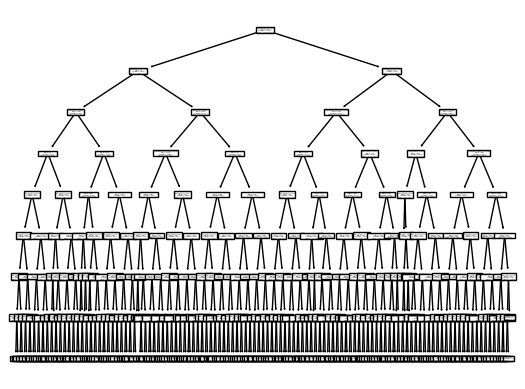

In [ ]:
from sklearn.tree import plot_tree,export_text
plot_tree(dcc,feature_names=sss_train.drop(["sentiment"], axis=1).columns.to_numpy());
#export_text(dcc,feature_names=sss_train.drop(["sentiment"], axis=1).columns.to_numpy())

In [ ]:
#print(export_text(dcc))

<h1>6- Random Forest</h1>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
# grid search
from sklearn.model_selection import GridSearchCV
param_grid={
    "criterion":["gini", "entropy", "log_loss"],
    "n_estimators":[80,120,150]
}
grid=GridSearchCV(rf,param_grid,cv=3,scoring="accuracy",verbose=2.5,return_train_score=True)
grid.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END criterion=gini, n_estimators=80;, score=(train=1.000, test=0.742) total time= 2.0min
[CV 2/3] END criterion=gini, n_estimators=80;, score=(train=1.000, test=0.743) total time= 1.9min
[CV 3/3] END criterion=gini, n_estimators=80;, score=(train=1.000, test=0.747) total time= 1.9min
[CV 1/3] END criterion=gini, n_estimators=120;, score=(train=1.000, test=0.748) total time= 2.9min
[CV 2/3] END criterion=gini, n_estimators=120;, score=(train=1.000, test=0.744) total time= 3.0min
[CV 3/3] END criterion=gini, n_estimators=120;, score=(train=1.000, test=0.748) total time= 2.9min
[CV 1/3] END criterion=gini, n_estimators=150;, score=(train=1.000, test=0.746) total time= 3.5min
[CV 2/3] END criterion=gini, n_estimators=150;, score=(train=1.000, test=0.743) total time= 3.4min
[CV 3/3] END criterion=gini, n_estimators=150;, score=(train=1.000, test=0.749) total time= 3.5min
[CV 1/3] END criterion=entropy, n_estimators=80;, sc

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [80, 120, 150]},
             return_train_score=True, scoring='accuracy', verbose=2.5)

In [ ]:
est=grid.best_estimator_
param_rf=grid.best_params_
param_rf

{'criterion': 'entropy', 'n_estimators': 150}

In [ ]:
# using best param from grid search in our model
rf=RandomForestClassifier(criterion='gini', n_estimators=param_rf["n_estimators"])
rf.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
pred_rf=rf.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred_rf)
print(acc)
final_accuracy["RF Classiier"]=acc
pred_rf0=dcc.predict(test3)
pred_rf0=submit(pred_rf0)
pred_rf0

0.7493241582698452


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,NEGATIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,NEGATIVE


<h1> 7- Bagging Clasifier </h1>

In [ ]:
# grid search
from sklearn.ensemble import BaggingClassifier
base=DecisionTreeClassifier(criterion='gini', max_depth=10)
bg=BaggingClassifier(estimator=base)
from sklearn.model_selection import GridSearchCV
param_grid={
    "n_estimators":[50,100,150]
}
grid=GridSearchCV(bg,param_grid,cv=5,scoring="accuracy",verbose=2.5,return_train_score=True)
grid.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END n_estimators=50;, score=(train=0.763, test=0.732) total time= 5.1min
[CV 2/5] END n_estimators=50;, score=(train=0.765, test=0.731) total time= 5.1min
[CV 3/5] END n_estimators=50;, score=(train=0.764, test=0.727) total time= 5.2min
[CV 4/5] END n_estimators=50;, score=(train=0.765, test=0.735) total time= 5.1min
[CV 5/5] END n_estimators=50;, score=(train=0.763, test=0.729) total time= 5.3min
[CV 1/5] END n_estimators=100;, score=(train=0.764, test=0.733) total time=10.4min
[CV 2/5] END n_estimators=100;, score=(train=0.765, test=0.732) total time=10.5min
[CV 3/5] END n_estimators=100;, score=(train=0.764, test=0.728) total time=10.9min
[CV 4/5] END n_estimators=100;, score=(train=0.766, test=0.736) total time=10.9min
[CV 5/5] END n_estimators=100;, score=(train=0.763, test=0.729) total time=10.5min
[CV 1/5] END n_estimators=150;, score=(train=0.763, test=0.733) total time=15.6min
[CV 2/5] END n_estimators=150;, 

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10)),
             param_grid={'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='accuracy', verbose=2.5)

In [ ]:
est=grid.best_estimator_
param_bg=grid.best_params_
param_bg

{'n_estimators': 100}

In [ ]:
from sklearn.ensemble import BaggingClassifier
# default estimator in bagging is : random Forest classifier
base=DecisionTreeClassifier(criterion='gini', max_depth= 20)
bg=BaggingClassifier(estimator=base,n_estimators=param_bg["n_estimators"])
bg.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
pred_bg=bg.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred_bg)
print(acc)
final_accuracy["Bagging Classiier"]=acc

0.7410911771934137


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
pred_bg=bg.predict(sss_test.drop(["sentiment"], axis=1))
confusion_matrix(sss_test["sentiment"],pred_bg)

array([[ 5871,  7628],
       [ 2907, 24284]])

In [ ]:
print(classification_report(sss_test["sentiment"],pred_bg))

              precision    recall  f1-score   support

         0.0       0.67      0.43      0.53     13499
         1.0       0.76      0.89      0.82     27191

    accuracy                           0.74     40690
   macro avg       0.71      0.66      0.67     40690
weighted avg       0.73      0.74      0.72     40690



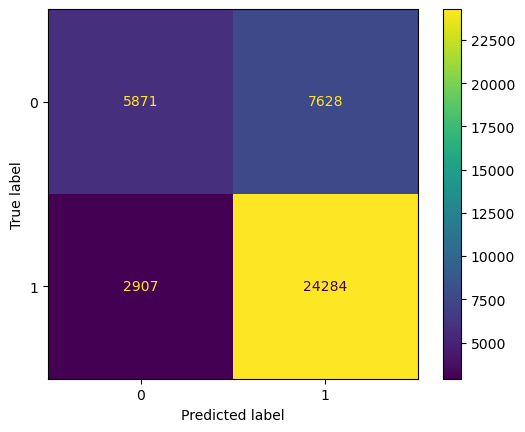

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(sss_test["sentiment"],pred_bg)).plot()

In [ ]:
from sklearn.metrics import classification_report
out1=classification_report(sss_test["sentiment"],pred_bg)
print(out1)

              precision    recall  f1-score   support

         0.0       0.67      0.43      0.53     13499
         1.0       0.76      0.89      0.82     27191

    accuracy                           0.74     40690
   macro avg       0.71      0.66      0.67     40690
weighted avg       0.73      0.74      0.72     40690



Text(0.5, 1.0, 'Precision Recall Curve')

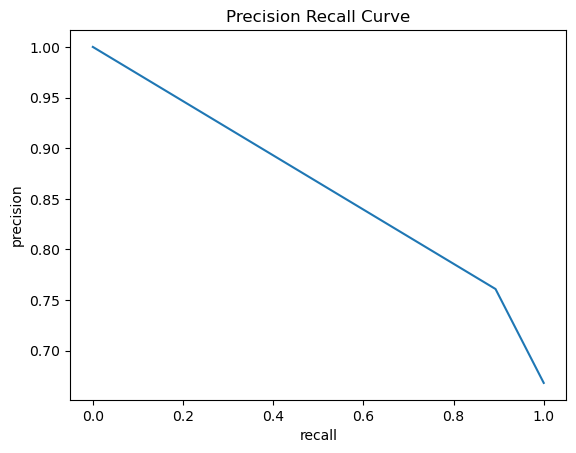

In [ ]:
from sklearn.metrics import precision_recall_curve
precision,recall,threshold=precision_recall_curve(sss_test["sentiment"],pred_bg)
plt.plot(recall,precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision Recall Curve")

Text(0.5, 1.0, 'ROC Curve')

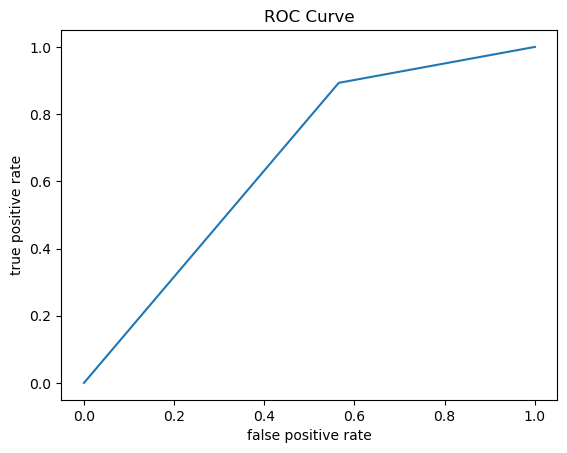

In [ ]:
from sklearn.metrics import roc_curve
fpr,tpr,threshold=roc_curve(sss_test["sentiment"],pred_bg)
plt.plot(fpr,tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")

In [ ]:
# best model yet
pred_bg=bg.predict(test3)
pred_bg=submit(pred_bg)
pred_bg
pred_bg.to_csv("submission.csv",index=False)
pd.read_csv("/kaggle/working/submission.csv")

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,NEGATIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE


<h1> 8-Boosting </h1>

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# default estimator in boosting is : Decision tree classifier
bost=BaggingClassifier(n_estimators=150)
bost.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
pred_bost=bost.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred_bost)
print(acc)
final_accuracy["Boosting Classiier"]=acc
pred_bost=bost.predict(test3)
pred_bost=submit(pred_bost)
pred_bost

0.7479233226837061


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE


<h1> 9- MLPClassifier </h1>

In [ ]:
from sklearn.neural_network import MLPClassifier
# first layer have 30, second layer have 60 and last layer have 1 neuron
mlp=MLPClassifier(hidden_layer_sizes=(30,60,90,60,30,10,5,1),max_iter=1000)
mlp.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
pred_mlp=mlp.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred_mlp)
print(acc)
final_accuracy["MLP Classiier"]=acc
pred_mlp=mlp.predict(test3)
pred_mlp=submit(pred_mlp)
pred_mlp

0.6682477267141804


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE


<h1> 10- Perceptron </h1>

In [ ]:
from sklearn.linear_model import Perceptron
# first layer have 30, second layer have 60 and last layer have 1 neuron
percept=Perceptron()
percept.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])

Perceptron()

perceptron acc:  0.5458589333988695


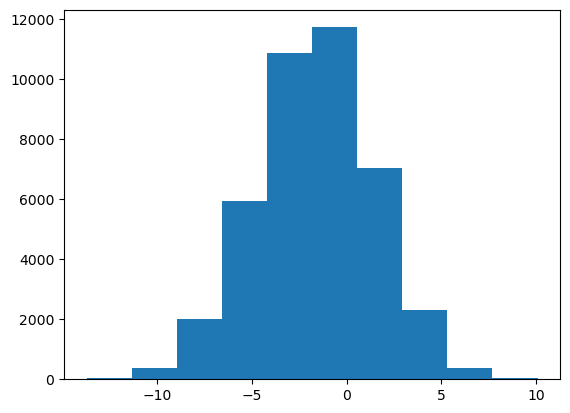

In [ ]:
pred_precept=percept.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred_precept)
print("perceptron acc: ",acc)
final_accuracy["Perceptron"]=acc
decision_function_score=percept.decision_function(sss_test.drop(["sentiment"], axis=1))
import seaborn as sns
plt.hist(decision_function_score);

Text(0.5, 1.0, 'Precision Recall Curve')

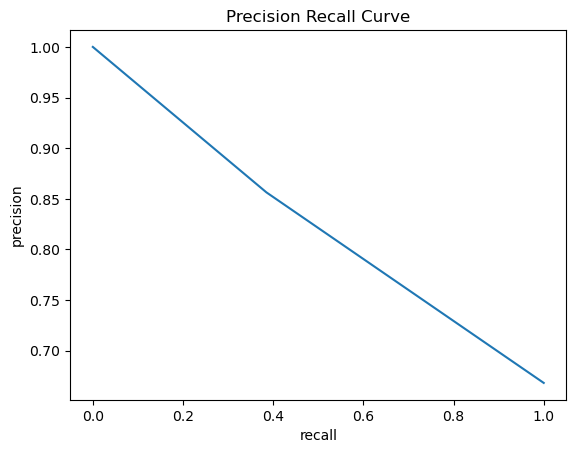

In [ ]:
from sklearn.metrics import precision_recall_curve,ConfusionMatrixDisplay
precision,recall,threshold=precision_recall_curve(sss_test["sentiment"],pred_precept,pos_label=1)
plt.plot(recall,precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision Recall Curve")

In [ ]:
from sklearn.metrics import auc
auc(precision,recall)

0.1579323251862941

Text(0.5, 1.0, 'precision recall tradeof')

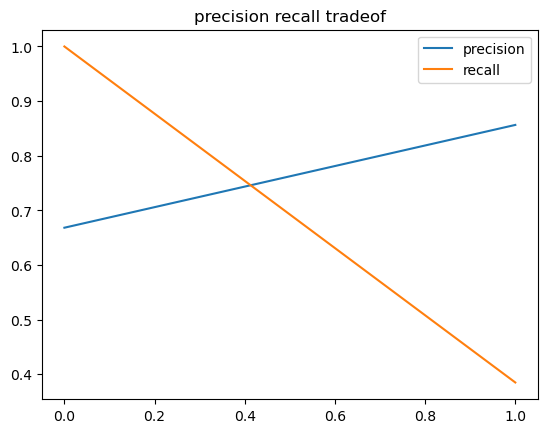

In [ ]:
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])
plt.legend(["precision","recall"])
plt.title("precision recall tradeof")

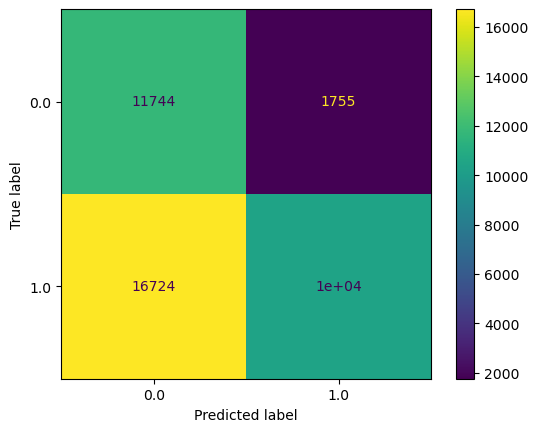

In [ ]:
ConfusionMatrixDisplay.from_predictions(sss_test["sentiment"],pred_precept)

In [ ]:
pred_precept=percept.predict(test3)
pred_precept=submit(pred_precept)
pred_precept

,id,sentiment
0,0,NEGATIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,NEGATIVE
...,...,...
55310,55310,NEGATIVE
55311,55311,NEGATIVE
55312,55312,NEGATIVE
55313,55313,NEGATIVE


<h2>2- Logistic Regression </h2>

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from  sklearn.svm import SVC

model1=LogisticRegression()

model1.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
pred1=model1.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred1)
print(acc)

pred1=model1.predict(test3)
pred1=submit(pred1)
pred1

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7378471368886704


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,NEGATIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE


<h1>LR:  Cross validation </h1>

In [ ]:

# k fold cross validation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import  KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score,precision_score,recall_score

# n-folds =1
kfold=KFold(n_splits=10)
model1=LogisticRegression()
k_score_linear0=cross_validate(model1,sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"], cv=kfold, return_estimator=True )

# k_score_svc=cross_validate(model0,xtrain,ytrain, cv=kfold,scoring=["accuracy","recall_macro"])

# #leave one out
# lou=LeaveOneOut()
# l_score_linear=cross_val_score(model1,xtrain,ytrain, cv=lou)
# l_score_svc=cross_val_score(model0,xtrain,ytrain, cv=lou)


# #shuffle split:  random permute cross validator
# ssplit=ShuffleSplit(n_splits=2, test_size=0.3)
# l_score_linear=cross_val_score(model1,xtrain,ytrain, cv=ssplit)
# l_score_svc=cross_val_score(model0,xtrain,ytrain, cv=ssplit)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
n=np.argmax(k_score_linear0["test_score"])
best_model1=k_score_linear0["estimator"][n]
print(k_score_linear0["test_score"][n],"best score by cv")
best_model1
pred_lr=best_model1.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],pred_lr)
print(acc)
final_accuracy["LR Classiier"]=acc

0.7424428606537232 best score by cv
0.7378471368886704


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Average Cross validation accuracy:  0.7369498078421781 +/- 0.005333917591956947


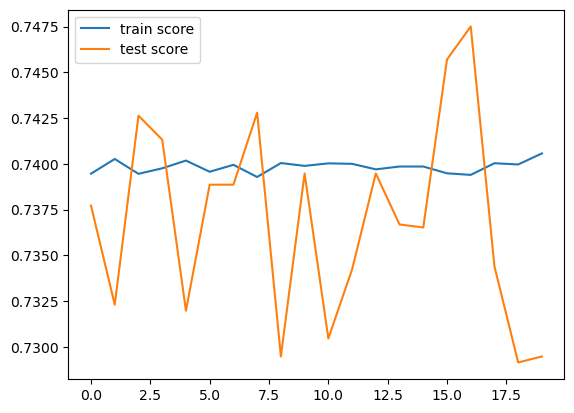

In [ ]:
k_score_linear=cross_validate(model1,sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"], cv=KFold(n_splits=20), scoring="accuracy" , return_train_score=True )
print("Average Cross validation accuracy: ",k_score_linear["test_score"].mean(),"+/-",  k_score_linear["test_score"].std())
k_score_linear.keys()

plt1=plt.subplot(1,1,1)
plt.plot(k_score_linear["train_score"]);
plt.plot(k_score_linear["test_score"]);
plt.legend(["train score","test score"])

<h3> LR: Model Weights Analysis </h3>

In [ ]:
# coeeficiant matrix  learned by cv estimators: to check stdev in wieghts by different estimators
coef1=pd.DataFrame(columns=sss_train.drop(["sentiment"], axis=1).columns)
coef1['intercept']=None
for i in k_score_linear0["estimator"]:
    val=np.append(i.coef_,i.intercept_)
    data=dict(zip(coef1.columns,val))
    coef2=pd.DataFrame(data,index=[0]).reset_index()
    coef1=pd.concat([coef1,coef2],ignore_index=True)
coef1=coef1.drop(["index"],axis=1)
coef1

,movieid,reviewerName,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,distributor,...,hash_492,hash_493,hash_494,hash_495,hash_496,hash_497,hash_498,hash_499,intercept,level_0
0,0.027981,-0.160728,1.169855,-0.102987,-0.030237,0.764028,0.027879,1.012660,-0.095155,-0.251720,...,0.853396,-0.468185,3.770990,-0.995013,-0.352369,-0.176311,-0.857456,-0.033362,-2.571830,0.0
1,0.031891,-0.165056,1.183701,-0.116361,-0.008152,0.735975,0.038611,0.946576,-0.087990,-0.254279,...,0.921094,-0.502059,3.864796,-1.013190,-0.327971,-0.273970,-1.039212,-0.037742,-2.628393,0.0
2,0.039642,-0.171875,1.141723,-0.146026,-0.016714,0.740622,0.031011,0.968758,-0.086375,-0.257464,...,0.906380,-0.343582,3.832792,-1.000674,-0.341057,-0.284342,-1.124213,-0.185938,-2.547990,0.0
3,0.035293,-0.176741,1.157427,-0.109272,-0.018149,0.735152,0.022938,0.962789,-0.093199,-0.249603,...,0.862537,-0.584440,3.712096,-1.038939,-0.247587,-0.245210,-1.185254,-0.178473,-2.549876,0.0
4,0.038764,-0.182215,1.124776,-0.099048,-0.003438,0.732943,0.036972,0.916469,-0.091169,-0.266122,...,0.870397,-0.361679,3.721481,-0.976838,-0.299265,-0.121526,-1.055191,-0.206868,-2.603121,0.0
5,0.044897,-0.172595,1.191540,-0.098551,-0.067229,0.769766,0.025172,0.971633,-0.097631,-0.253931,...,0.785785,-0.559973,3.889410,-1.192543,-0.259723,-0.218298,-1.113193,-0.110640,-2.583739,0.0
6,0.026790,-0.170354,1.181421,-0.096873,-0.043576,0.769205,0.025233,1.014092,-0.092275,-0.245811,...,0.994238,-0.324113,3.791959,-1.080844,-0.371354,-0.107441,-1.127742,-0.062320,-2.604741,0.0
7,0.020036,-0.156447,1.145013,-0.097831,-0.011861,0.737111,0.026660,0.977547,-0.094425,-0.260498,...,0.853761,-0.433793,3.803093,-0.899324,-0.374192,-0.208244,-1.047604,0.051310,-2.588353,0.0
8,0.021976,-0.176275,1.165966,-0.116805,-0.026021,0.754666,0.035073,0.933780,-0.098360,-0.264476,...,0.835857,-0.339091,3.695462,-1.097801,-0.373637,-0.207157,-1.022335,-0.002259,-2.542580,0.0
9,0.020921,-0.162516,1.199235,-0.096440,-0.036381,0.764254,0.028525,0.978516,-0.096196,-0.252669,...,0.885839,-0.466821,3.905830,-1.021020,-0.335183,-0.141264,-1.221964,-0.141047,-2.629933,0.0


Text(0.5, 1.0, 'boxplot plot for weights estimation by estimators')

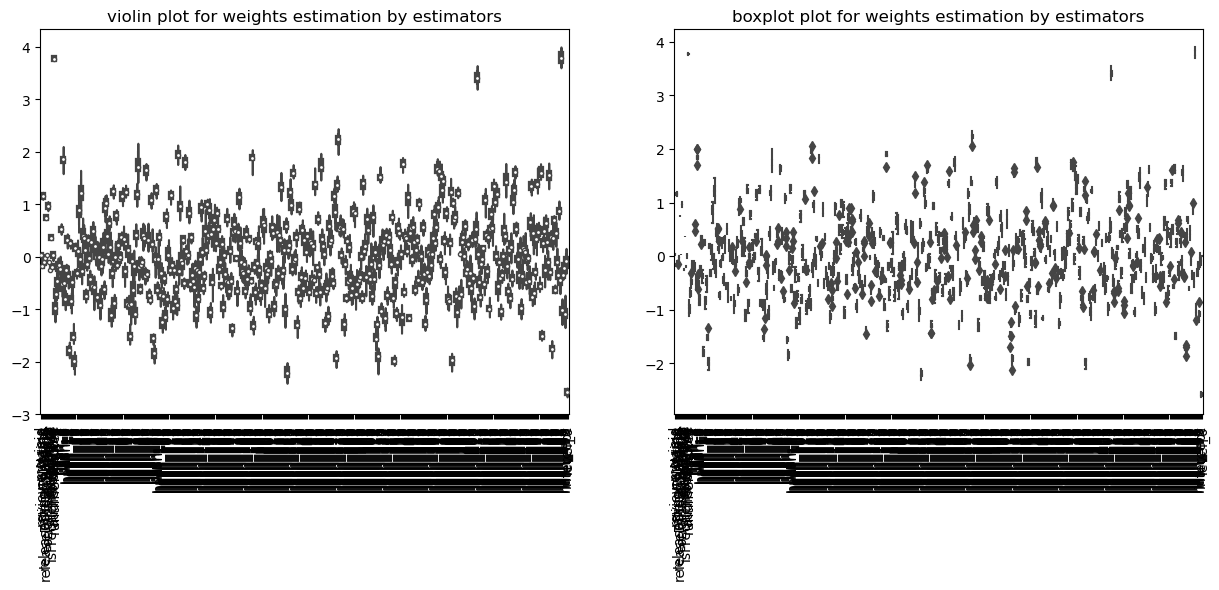

In [ ]:
plt.subplots(1,2, figsize=(15,5))
plt.subplot(1,2,1)
plot2=sns.violinplot(coef1)
plot2.set_xticklabels(plot2.get_xticklabels(),rotation=90);
plt.title("violin plot for weights estimation by estimators")
plt.subplot(1,2,2)
plot1=sns.boxplot(coef1)
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90);
plt.title("boxplot plot for weights estimation by estimators")

Text(0.5, 1.0, 'correlation among eatures')

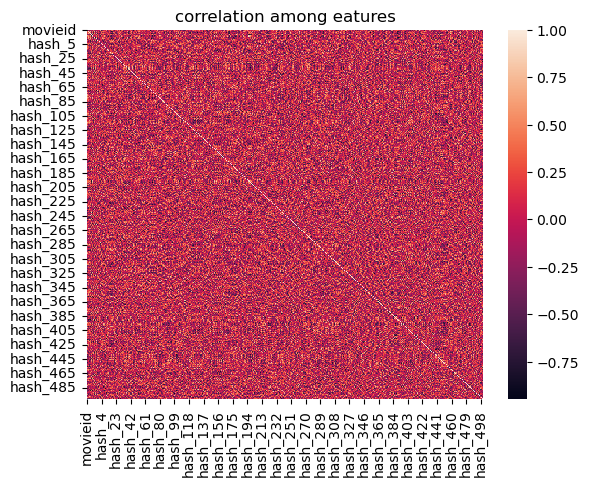

In [ ]:
sns.heatmap(coef1.corr())
plt.title("correlation among eatures")

In [ ]:
from sklearn.feature_selection import mutual_info_regression
mir_data=mutual_info_regression(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
mir_data

array([1.42292278e-01, 3.40737825e-02, 2.24653227e-03, 8.58953111e-02,
       5.10293929e-02, 4.13477516e-02, 3.57940445e-02, 7.89862611e-03,
       8.85929949e-02, 3.43192739e-02, 1.62968929e-02, 1.39829512e-03,
       5.68572181e-02, 1.36758465e-01, 5.51428141e-02, 9.90669362e-03,
       0.00000000e+00, 1.86467371e-03, 1.19675394e-03, 0.00000000e+00,
       0.00000000e+00, 2.86099926e-03, 3.01932371e-03, 3.53633310e-03,
       0.00000000e+00, 2.20484836e-03, 0.00000000e+00, 1.55574817e-03,
       0.00000000e+00, 0.00000000e+00, 8.39936023e-04, 0.00000000e+00,
       0.00000000e+00, 2.19193459e-04, 2.60666494e-03, 4.47774748e-03,
       0.00000000e+00, 0.00000000e+00, 3.80731605e-03, 3.60834569e-04,
       0.00000000e+00, 1.18453640e-03, 0.00000000e+00, 0.00000000e+00,
       2.87356252e-03, 1.94675764e-03, 0.00000000e+00, 1.78901097e-04,
       2.70465013e-03, 1.31368966e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.40841594e-03, 0.00000000e+00, 1.23252152e-03,
      

In [ ]:
weight_avg=coef1.mean(axis=0)[:-1]
weight_avg

movieid                0.030819
reviewerName          -0.169480
rating                 1.166066
ratingContents        -0.108019
releaseDateTheaters   -0.026176
                         ...   
hash_496              -0.328234
hash_497              -0.198376
hash_498              -1.079416
hash_499              -0.090734
intercept             -2.585056
Length: 516, dtype: float64

/tmp/ipykernel_21/1333305888.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt1.set_xticklabels(plt1.get_xticklabels(),rotation=90);


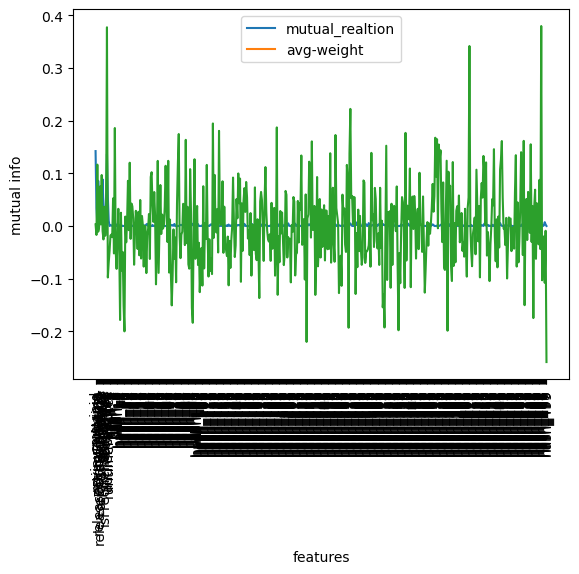

In [ ]:
plt1=plt.subplot(1,1,1);

plt.plot(list(sss_train.drop(["sentiment"], axis=1).columns),mir_data,0);
plt.plot(list(sss_train.drop(["sentiment"], axis=1).columns),weight_avg/10);
plt1.set_xticklabels(plt1.get_xticklabels(),rotation=90);
plt.xlabel("features")
plt.ylabel("mutual info")
plt.legend(["mutual_realtion","avg-weight"])

<h3> LR: Hyper Parameter Search</h3>

In [ ]:

# learning curve : for varing train size
from sklearn.model_selection import learning_curve
# 1%, 10%, 20%..........100% data uzsed to get curve
train_sizes=np.linspace(0.1,1,5)
learncurve=learning_curve(model1,sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"], train_sizes=train_sizes) # default use 5 cv fold
learncurve # train_sizes, train_acc, test_acc
print("Average train accuracy: ",learncurve[1].mean(),"+/-",  round(learncurve[1].std(),2))
print("Average test accuracy: ",learncurve[2].mean(),"+/-",  round(learncurve[2].std(),2))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Average train accuracy:  0.743841831977672 +/- 0.0
Average test accuracy:  0.7343234874355059 +/- 0.0


Text(0.5, 1.0, 'Test Acc vs train size')

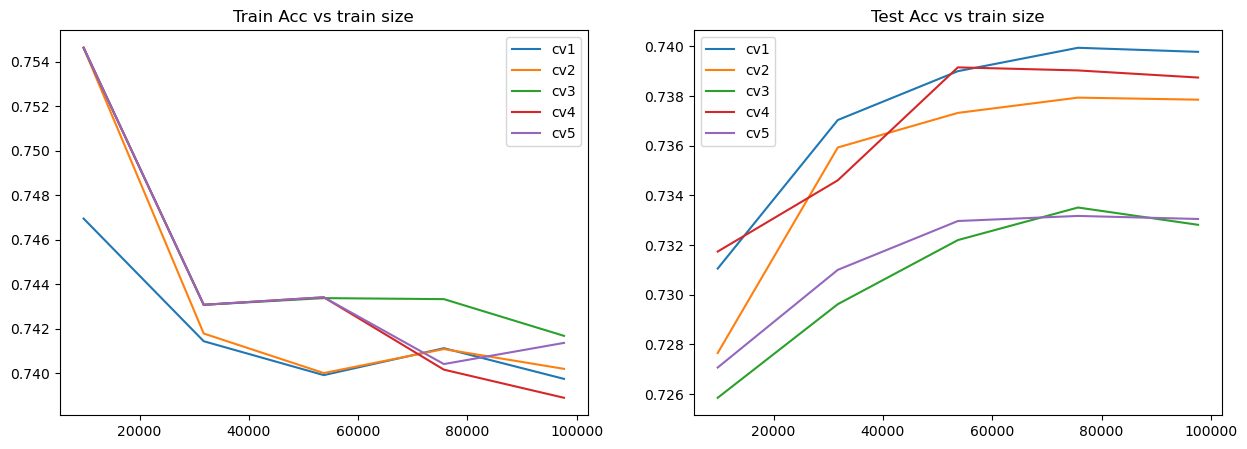

In [ ]:
plt.subplots(1,2, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(learncurve[0],learncurve[1]);
plt.legend(["cv1","cv2","cv3","cv4","cv5"])
plt.title("Train Acc vs train size")
plt.subplot(1,2,2)
plt.plot(learncurve[0],learncurve[2]);
plt.legend(["cv1","cv2","cv3","cv4","cv5"])
plt.title("Test Acc vs train size")

<h3>SGD: Hyper paramer Search </h3>
<ul>
    <li> grid search </li>
    <li> Randomnizedsearch </li>
 </ul>

In [ ]:
# validation curve: or varying param
from sklearn.model_selection import validation_curve
from sklearn.linear_model import SGDClassifier

early_learning_rate=1e-1
sgd=SGDClassifier(loss="log_loss",eta0=early_learning_rate,validation_fraction=0.3)
eta1=np.linspace(0.1,1e-7,10)
train_loss,test_loss=validation_curve(sgd,sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"],cv=3,param_name="eta0",param_range=eta1)
train_loss,test_loss

(array([[0.7372017 , 0.7380651 , 0.7334939 ],
        [0.73790214, 0.73907273, 0.73425577],
        [0.73607117, 0.73613586, 0.73794222],
        [0.73798815, 0.73606213, 0.73918333],
        [0.73691907, 0.73928163, 0.73871638],
        [0.73802502, 0.7376473 , 0.7384829 ],
        [0.73730001, 0.73586552, 0.73893756],
        [0.73592371, 0.73747527, 0.73877782],
        [0.73642754, 0.7389007 , 0.73879011],
        [0.73624321, 0.73589009, 0.7373401 ]]),
 array([[0.73710986, 0.73344147, 0.73243383],
        [0.73585648, 0.733933  , 0.73317113],
        [0.73465225, 0.73154907, 0.73336774],
        [0.73779798, 0.73169653, 0.73612033],
        [0.73524207, 0.73405589, 0.73567795],
        [0.73728189, 0.73179483, 0.7357271 ],
        [0.73578275, 0.72938632, 0.73609575],
        [0.73406242, 0.73381012, 0.73548133],
        [0.73605308, 0.73395758, 0.73548133],
        [0.73455394, 0.72990243, 0.73285163]]))

In [ ]:
index_max_accuracy=np.argmax(train_loss.sum(axis=1)/3)
best_eta=eta1[index_max_accuracy]
best_eta

0.055555600000000004

In [ ]:
from sklearn.model_selection import GridSearchCV

grid=GridSearchCV(estimator=SVC(),
                  param_grid={"kernel":["linear","poly"],
                              "degree":[1,5],
                              "C":[0.1,8]
                             },
                  verbose=2,
                  scoring="accuracy"
                 )
#grid.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])

In [ ]:
model3=SGDClassifier(loss="log_loss",eta0=best_eta,validation_fraction=0.3)
model3.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
pred33=model3.predict(sss_test.drop(["sentiment"],axis=1))


from sklearn.metrics import log_loss, accuracy_score
print("log loss :",log_loss(sss_test["sentiment"],pred33))
print("accuracy: ",accuracy_score(sss_test["sentiment"],pred33))
final_accuracy["SGD Classiier"]=accuracy_score(sss_test["sentiment"],pred33)
pred3=model3.predict(test3)
pred3=submit(pred3)
pred3

log loss : 9.492351676524438
accuracy:  0.7366429098058491


,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,NEGATIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE


<h1> Naive Bayes </h1>

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
GNB=GaussianNB()
GNB.fit(sss_train.drop(["sentiment"], axis=1),sss_train["sentiment"])
GNBpred1=GNB.predict(sss_test.drop(["sentiment"], axis=1))
acc=accuracy_score(sss_test["sentiment"],GNBpred1)
print(acc)
final_accuracy["GaussianNB Classiier"]=acc
pred1=GNB.predict(test3)
pred1=submit(pred1)
pred1

0.6423199803391497


,id,sentiment
0,0,POSITIVE
1,1,NEGATIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE


<h1> Final Submission </h1>

In [ ]:
#pred3.to_csv("submission.csv", index=False)
pd.read_csv("/kaggle/working/submission.csv")

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,NEGATIVE
55311,55311,POSITIVE
55312,55312,POSITIVE
55313,55313,POSITIVE


<h1> Results </h1>

{'Dummy Classiier': 0.6682477267141804, 'KNN Classiier': 0.7004177930695502, 'DTC Classiier': 0.7181862865568935, 'RF Classiier': 0.7493241582698452, 'Bagging Classiier': 0.7410911771934137, 'Boosting Classiier': 0.7479233226837061, 'MLP Classiier': 0.6682477267141804, 'Perceptron': 0.5458589333988695, 'LR Classiier': 0.7378471368886704, 'SGD Classiier': 0.7366429098058491, 'GaussianNB Classiier': 0.6423199803391497}


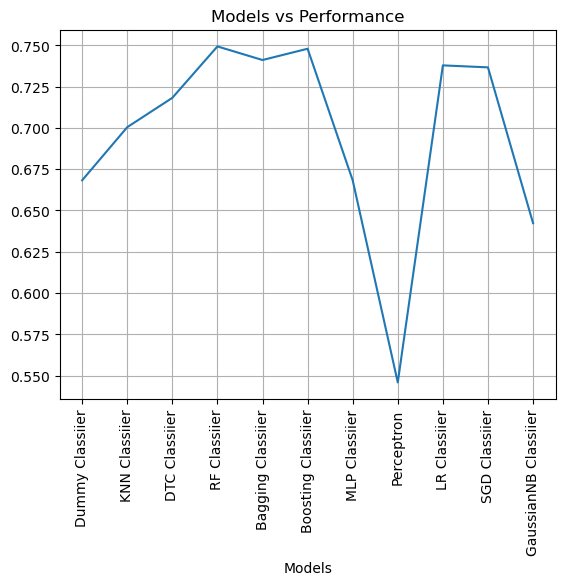

In [ ]:
print(final_accuracy)
key=final_accuracy.keys()
val=final_accuracy.values()
plt.plot(key,val);
plt.xlabel("Models")
plt.title("Models vs Performance")
plt.xticks(rotation=90);
plt.grid()

<h1> ----------------------------END------------------------------ </h1>